In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
df = pd.read_csv("cardata.csv")

In [117]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [55]:
print(df.describe())

              Year  Selling_Price  Present_Price     Kms_Driven       Owner
count   299.000000     299.000000     299.000000     299.000000  299.000000
mean   2013.615385       4.589632       7.541037   36916.752508    0.043478
std       2.896868       4.984240       8.567887   39015.170352    0.248720
min    2003.000000       0.100000       0.320000     500.000000    0.000000
25%    2012.000000       0.850000       1.200000   15000.000000    0.000000
50%    2014.000000       3.510000       6.100000   32000.000000    0.000000
75%    2016.000000       6.000000       9.840000   48883.500000    0.000000
max    2018.000000      35.000000      92.600000  500000.000000    3.000000


In [56]:
# On fait la distinction entre variables quantitatives et variables qualitatives

num_col = list(df.describe().columns) 
cat_col = list(df.drop(num_col, axis=1).columns)

num_col, cat_col

(['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner'],
 ['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission'])

In [57]:
num_df = df[num_col]
cat_df = df[cat_col]

## Détection outliers

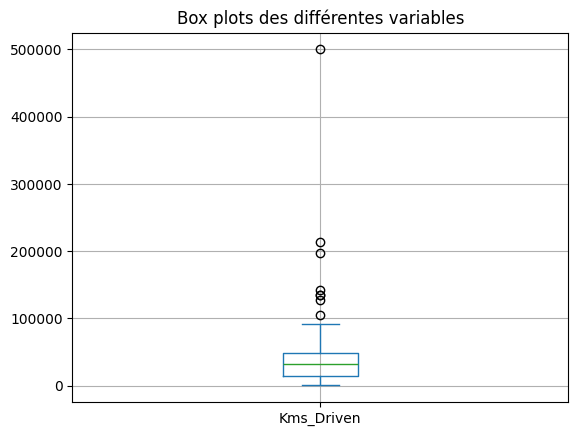

In [153]:
num_df['Kms_Driven'].plot.box()
plt.title('Box plots des différentes variables')
plt.grid()
plt.show()

Il y a des outliers sur Kms_Driven, mais il faut bien faire la distinction entre une valeur extrême et une valeur aberrante, savoir identifier des outliers avec les techniques ci-dessous est important mais il faut garder à l'esprit qu'une valeur extrême peut être tout aussi légitime qu'une valeur proche de la médiane.

Tout dépend du contexte, une voiture avec un kilométrage de 500 000 km est extrême mais reste plausible, une voiture ayant un kilométrage de 2 milliards de km est aberrant.

### IQR Rule

$(x < (Q_1 - 1.5 \times \mathrm{IQR})) \lor (x > (Q_3 + 1.5 \times \mathrm{IQR}))$

In [59]:
def get_outliers_iqr(serie):
    # https://online.stat.psu.edu/stat200/lesson/3/3.2

    """
    Fonction qui renvoie un vecteur booléen de longueur N
    True si la valeur de la série est outlier selon IQR rule
    Args    
        pd.Serie: la série pandas de longueur N
    """

    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((serie < (Q1 - 1.5 * IQR)) | (serie > (Q3 + 1.5 * IQR)))

    return outliers

In [60]:
sum(get_outliers_iqr(num_df['Kms_Driven']))

8

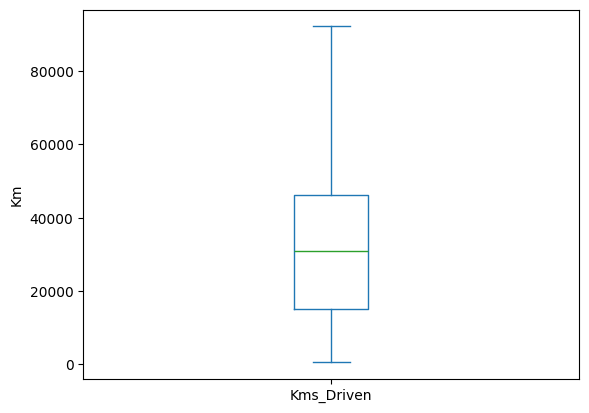

In [61]:
# Le box plot de "Kms_Driven" sans les outliers

num_df['Kms_Driven'][~get_outliers_iqr(num_df['Kms_Driven'])].plot.box()
plt.ylabel("Km")
plt.show()

### Z-score

In [62]:
from scipy.stats import zscore

La technique du z_score revient à écarté le score z d'une valeur dans une colonne, par convention, un z_score supérieur à 3 nous renseigne sur un outlier, mais encore une fois il faut prendre en compte le contexte.

On notera que le z score d'un valeur est sa valeur standardisé (soustrait par la moyenne de la série puis divisé par l'écart type de la série)

In [63]:
z_scores = np.abs(zscore(num_df["Kms_Driven"]))
outliers_z = (z_scores > 3)
print("Valeurs aberrantes détectées (Z-score):")
print(outliers_z.sum())

Valeurs aberrantes détectées (Z-score):
3


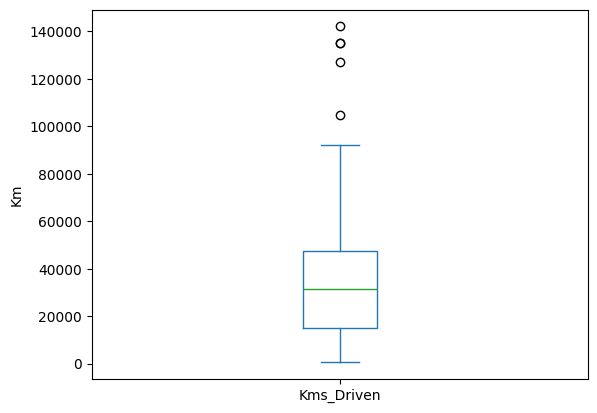

In [64]:
num_df['Kms_Driven'][~outliers_z].plot.box()
plt.ylabel("Km")
plt.show()

## Test de normalité

In [15]:
kms = df['Kms_Driven']

### Première visualisation

In [17]:
kms_sim = np.random.normal(loc=kms.mean(), scale=kms.std(), size=(kms.shape))
kms_sim.shape

(299,)

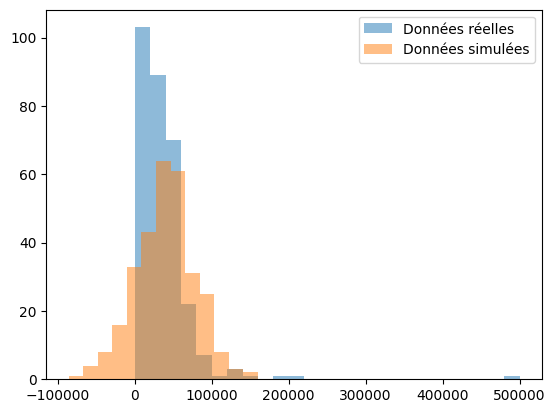

In [24]:
plt.hist(kms, alpha=0.5, label="Données réelles", bins="scott")
plt.hist(kms_sim, alpha=0.5, label="Données simulées", bins="scott")
plt.legend()
plt.show()

### Test de Shapiro-Wilk

In [26]:
from scipy.stats import shapiro

In [29]:
# Test
stat, p_value = shapiro(kms)

In [ ]:
print("Statistique du test :", stat)
print("p-value :", p_value)

# Interprétation
alpha = 0.05
if p_value > alpha:
    print("On ne peut PAS rejeter l'hypothèse de normalité (distribution plausible normale)")
else:
    print("On rejette l'hypothèse de normalité (distribution peu plausible normale)")

# Si la p-value a une valeur très faible, alors on rejete l'hypothèse nulle (hypothèse de normalité), on fixe le seuil à 0,05 % (alpha)

Statistique du test : 0.5933105547809816
p-value : 6.268642144714251e-26
On rejette l'hypothèse de normalité (distribution peu plausible normale)


In [45]:
results = {}
print("Résultats du test de Shapiro-Wilk :")
for col in num_df.columns:
    stat, p_value = shapiro(num_df[col])
    results[col] = {'statistique': stat, 'p-value': p_value}
    if p_value > 0.05:
        conclusion = "normalité plausible"
    else:
        conclusion = "normalité rejetée"
    print(f"{col} : p-value={p_value:.4f} => {conclusion}")

Résultats du test de Shapiro-Wilk :
Year : p-value=0.0000 => normalité rejetée
Selling_Price : p-value=0.0000 => normalité rejetée
Present_Price : p-value=0.0000 => normalité rejetée
Kms_Driven : p-value=0.0000 => normalité rejetée
Owner : p-value=0.0000 => normalité rejetée


### Test d’Anderson-Darling

In [12]:
from scipy.stats import anderson

In [ ]:
# Test d'Anderson-Darling

result_anderson = anderson(kms, dist='norm')  # 'norm' pour tester la normalité

In [14]:
print("Statistique du test :", result_anderson.statistic)
print("Critères de rejet :", result_anderson.critical_values)
print("Significations :", result_anderson.significance_level)

# Interprétation
for cv, sig_level in zip(result_anderson.critical_values, result_anderson.significance_level):
    if result_anderson.statistic > cv:
        print(f"La normalité est rejetée au seuil {sig_level}%")
    else:
        print(f"La normalité n'est PAS rejetée au seuil {sig_level}%")

Statistique du test : 17.640102699091642
Critères de rejet : [0.569 0.648 0.777 0.906 1.078]
Significations : [15.  10.   5.   2.5  1. ]
La normalité est rejetée au seuil 15.0%
La normalité est rejetée au seuil 10.0%
La normalité est rejetée au seuil 5.0%
La normalité est rejetée au seuil 2.5%
La normalité est rejetée au seuil 1.0%


Voir :

* https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test

## Corrélation entre quantitatives (linéaire : Pearson)

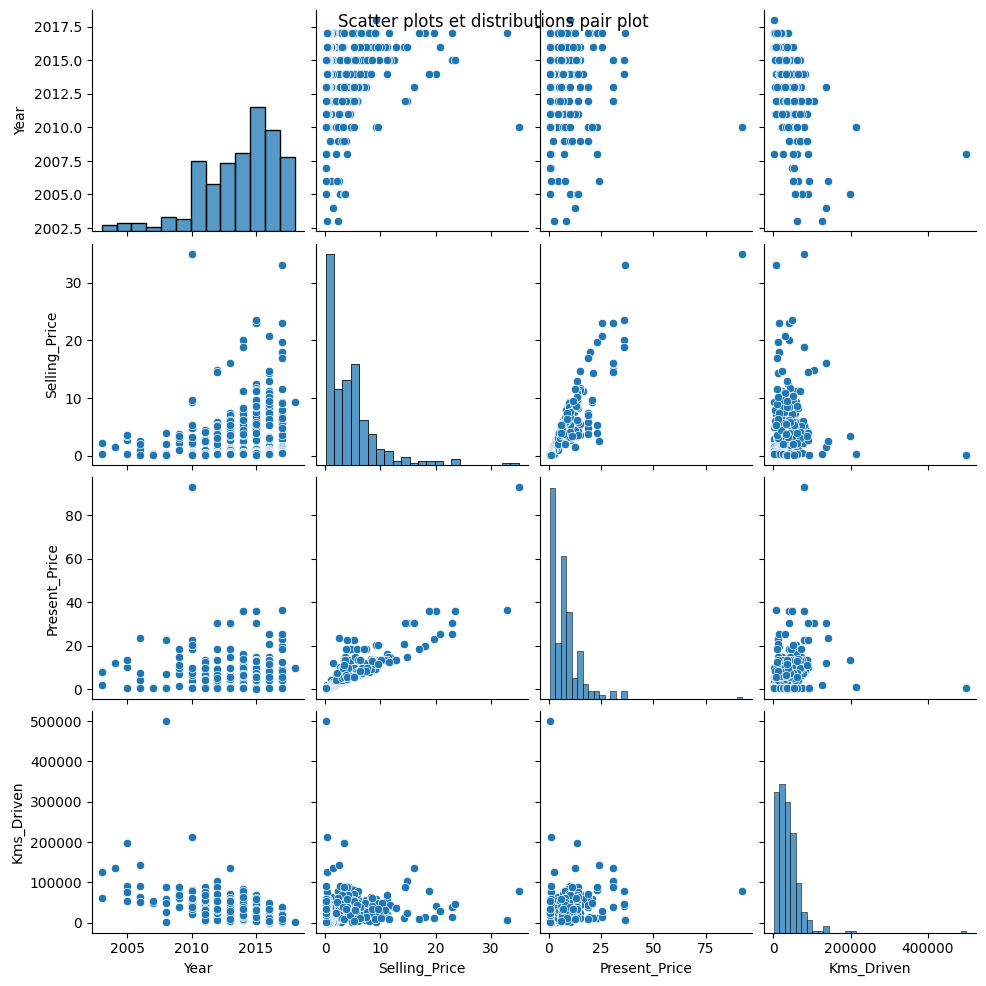

In [89]:
sns.pairplot(num_df)
plt.suptitle('Scatter plots et distributions pair plot')
plt.show()

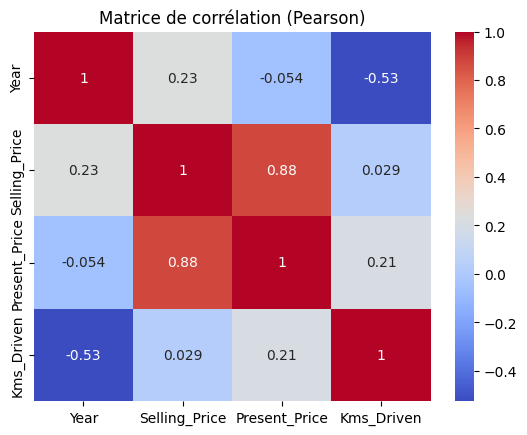

In [90]:
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation (Pearson)')
plt.show()

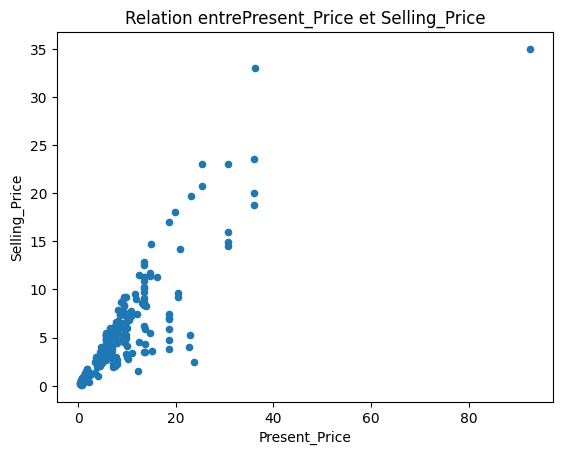

In [ ]:
df.plot.scatter(x='Present_Price', y='Selling_Price')
plt.title('Relation entre Present_Price et Selling_Price')
plt.show()

## Lien quantitative - qualitative

In [64]:
df.Fuel_Type.unique()

array(['Petrol', 'Diesel', 'CNG'], dtype=object)

In [65]:
df.Fuel_Type.value_counts()

Fuel_Type
Petrol    239
Diesel     58
CNG         2
Name: count, dtype: int64

In [69]:
# On va exclure CNG (ce sont les véhicules au gaz) l'effectif de cette modalité est bien trop faible

df_not_cng = df[df.Fuel_Type != 'CNG']

In [70]:
df_not_cng.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


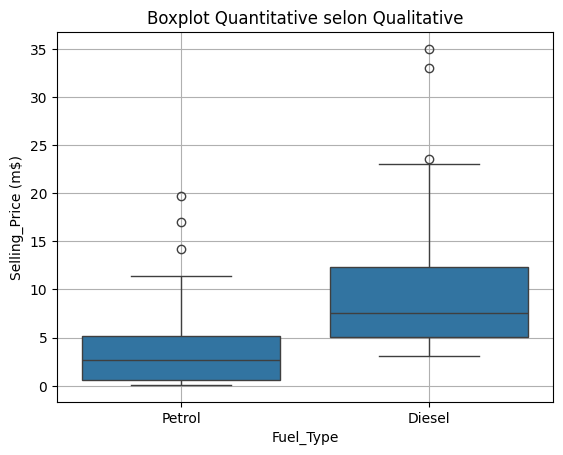

In [71]:
# Visualisation par boxplot
sns.boxplot(x='Fuel_Type', y='Selling_Price', data=df_not_cng)
plt.title('Boxplot Quantitative selon Qualitative')
plt.ylabel("Selling_Price (m$)")
plt.grid()
plt.show()

### Test statistique : Kruskal-Wallis

In [131]:
from scipy.stats import kruskal

In [132]:
# Test statistique : Kruskal-Wallis
grouped = [df_not_cng[df_not_cng['Fuel_Type'] == k]['Selling_Price'] for k in df_not_cng['Fuel_Type'].unique()]

stat, p_value = kruskal(*grouped)
print(f"Test de Kruskal-Wallis: Stat={stat}, p-value={p_value}")

Test de Kruskal-Wallis: Stat=74.87396542180795, p-value=5.017429640719032e-18


La p value est largement en dessous de 0,05 : Il existe au moins une différence significative entre les groupes comparés (on rejette l'hypothèse nulle)

### Test de Mann-Whitney

In [73]:
from scipy.stats import mannwhitneyu

In [75]:
petrol = df_not_cng[df_not_cng['Fuel_Type'] == 'Petrol']['Selling_Price']
diesel = df_not_cng[df_not_cng['Fuel_Type'] == 'Diesel']['Selling_Price']

# Test de Mann-Whitney
stat, p_value = mannwhitneyu(petrol, diesel)
print(f"Test de Mann-Whitney: Stat={stat}, p-value={p_value}")

Test de Mann-Whitney: Stat=1854.5, p-value=5.055051337614678e-18


Ici la p value est bien en dessous de 0,05, on peut alors rejeter l'hypothèse selon laquelle il y a une indépendance en Selling_Price et Fuel_Type

https://perso.ens-lyon.fr/lise.vaudor/grimoireStat/_book/etablir-le-lien-entre-deux-variables-tests-dhypothese.html

### ANOVA one way

In [122]:
from scipy.stats import f_oneway

In [129]:
df_not_cng.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [133]:
f_stat, p_value = f_oneway(*grouped)

print("F-statistic:", f_stat)
print("P-value:", p_value)

F-statistic: 123.45153808685052
P-value: 3.4228922837475726e-24


On peut rejetter l’hypothèse nulle, il y a une dépendance entre les deux variables.

#### ETA squared

In [150]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [154]:
def eta_squared(serie_quali, serie_quanti):
    serie_quanti_mean = serie_quanti.mean()

    # moyenne de y par classe et effectif par classe
    grp = serie_quanti.groupby(serie_quali).agg(['mean', 'count'])

    # somme des carrés expliquée
    SCE = ((grp['mean'] - serie_quanti_mean)**2 * grp['count']).sum()

    # somme des carrés totale
    SCT = ((serie_quanti - serie_quanti_mean)**2).sum()

    return SCE / SCT

eta_squared(df_not_cng["Fuel_Type"], df_not_cng["Selling_Price"])

np.float64(0.29501991712413766)

Eta squared indique quelle proportion de la variance totale de la variable quantitative est expliquée par le facteur catégoriel.

Ici η² ≈ 0.29 → le type de carburant explique environ 29 % de la variance du prix de vente.

L'eta squared est élevé, indiquant une dépendance entre ces deux variables

source : https://www.statology.org/eta-squared/

## Corrélation qualitative - qualitative

### Chi2

In [70]:
df_not_cng.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [71]:
from scipy.stats import chi2_contingency

In [ ]:
# On réalise d'abord le tableau de contingence avec pd.crosstab()
contingency_table = pd.crosstab(df_not_cng['Fuel_Type'], df_not_cng['Transmission'])
contingency_table

# https://fr.wikipedia.org/wiki/Tableau_de_contingence

Transmission,Automatic,Manual
Fuel_Type,,
Diesel,11,47
Petrol,28,211


In [104]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Test du Chi-2 : Stat={chi2}, p-value={p}")

Test du Chi-2 : Stat=1.562071743345923, p-value=0.21136213487184588


p-value = 0.21 (nettement supérieure à 0,05) : on ne peut pas rejeter l’hypothèse d’indépendance entre Fuel_Type et  Transmission 

### V de Cramér

$V = \sqrt{\chi^{2} / (n * min(k-1, r-1))}$

In [76]:
n = len(df_not_cng) # n : nombre d'individus
k = df_not_cng['Transmission'].nunique() # k : nombre de modalités pour la première catégorielle
r = df_not_cng['Fuel_Type'].nunique() # r : nombre de modalités pour la deuxième catégorielle

n, k , r

(297, 2, 2)

In [86]:
V = np.sqrt(chi2 / (n * min(k-1, r-1)))

In [87]:
print(f"V de Cramér : {V}")

V de Cramér : 0.07252241597841692


Le calcul de V de Cramér nous donne un association faible, l'indicateur est situé entre 0 et 1.

Nous utilisons généralement les intervalles suivants :
* Entre 0 et 0.1 : association nulle / quasi nulle
* Entre 0.1 et 0.3 : association faible
* Entre 0.3 et 0.5 : association moyenne
* Supérieur à 0.5 : association significative/forte

### Fréquences conditionnelles (plus difficilement interprétable)

Les fréquences conditionnelles mesurent la proportion d’une modalité d’une variable conditionnellement à une autre variable. Autrement dit, elles répondent à la question : quelle est la répartition d’une variable selon une autre ?

Le calcul de chi2 utilise un calcul de fréquences.

In [100]:
contingency_table

Transmission,Automatic,Manual
Fuel_Type,,
Diesel,11,47
Petrol,28,211


In [97]:
# Fréquences conditionnelles par modalité de 'Fuel_Type'
freq_cond_Fuel_Type = contingency_table.div(contingency_table.sum(axis=1), axis=0)

print(freq_cond_Fuel_Type)

Transmission  Automatic    Manual
Fuel_Type                        
Diesel         0.189655  0.810345
Petrol         0.117155  0.882845


Interprétation : 81,03% des voitures "Diesel" sont de type Transmission "Manual"

In [98]:
# Fréquences conditionnelles par modalité de 'Transmission'

freq_cond_Transmission = contingency_table.div(contingency_table.sum(axis=0), axis=1)

print(freq_cond_Transmission)

Transmission  Automatic    Manual
Fuel_Type                        
Diesel         0.282051  0.182171
Petrol         0.717949  0.817829


Interprétation : 18,21% des voitures de type Transmission "Manual" sont de type "Diesel" 

Deux variables qualitatives A et B sont formellement indépendantes l'une de l'autre si :

$$P(A = a_{i} | B = b_{i}) = P(A = a_{i})$$

et

$$P(B = b_{i} | A = a_{i}) = P(B = b_{i})$$

Pour toutes les modalités : $a_{i}$ et $b_{i}$

Autrement dit, la connaissance de la modalité de l’une ne change pas la probabilité de l’autre.

### Fisher

In [109]:
from scipy.stats import fisher_exact

In [110]:
# Test exact de Fisher (par défaut, 'two-sided')
oddsratio, p_value = fisher_exact(contingency_table, alternative='two-sided')

print(f"Odds ratio = {oddsratio:.3f}")
print(f"p-value = {p_value:.4f}")

Odds ratio = 1.764
p-value = 0.1910


Hypothèse nulle : les deux variables sont indépendantes (pas d’association).
Si p-value < 0,05, on rejette l'hypothèse nulle.

Ici on ne peut pas rejetter l'hypothèse nulle.

Si l'odds ratio est 1, il n'y a pas de corrélation

Si l'odds ratio est supérieur à 1, la première variable influence la deuxième.

Si l'odds ratio est inférieur à 1, c'est l'inverse.

## Exercice

Obtenez le corrélation de spearman entre chaque variable quantitative

Obtenez la corrélation entre Fuel_Type et Owner et donnez vos conclusions.